# Wikipedia Sentiment + Bitcoin Price — Algo Trading Notebook

This notebook builds a **simple algorithmic trading signal** for Bitcoin using:

1. **Wikipedia edit activity** on the `Bitcoin` page
2. **Sentiment analysis** of edit comments
3. **BTC-USD daily prices** from Yahoo Finance

We then:
- Construct daily features from Wikipedia edits
- Merge them with Bitcoin price data
- Train a simple model to predict **next-day price direction**
- Evaluate the strategy performance on a test set


## 0. Setup
Uncomment and run the following cell if you don't have the required libraries installed.


In [ ]:
!pip install mwclient transformers yfinance tqdm
!pip install torch --index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://download.pytorch.org/whl/cpu


## 1. Imports & Configuration

In [ ]:
import time
from datetime import datetime, timedelta

import mwclient
import pandas as pd
import numpy as np
import yfinance as yf
from tqdm import tqdm

from transformers import pipeline

import matplotlib.pyplot as plt

plt.style.use('ggplot')

# ---- Configuration ----
WIKI_SITE = 'en.wikipedia.org'
WIKI_PAGE_TITLE = 'Bitcoin'

# Date range for analysis
# You can adjust these
START_DATE = '2024-01-01'
END_DATE   = '2024-02-01'

# Ticker for Bitcoin (USD) on Yahoo Finance
BTC_TICKER = 'BTC-USD'

START_DT = datetime.fromisoformat(START_DATE)
END_DT   = datetime.fromisoformat(END_DATE)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

## 2. Download Wikipedia Revisions
We use the `mwclient` library to fetch the revision history of the Bitcoin page.
Each revision has:
- `timestamp`
- `user`
- `comment` (edit summary)
- other metadata


In [ ]:
def fetch_wiki_revisions(page_title: str,
                          start_dt: datetime,
                          end_dt: datetime,
                          max_retries: int = 5):
    """Fetch revisions for a Wikipedia page between start_dt and end_dt.

    Returns a list of revision dicts.
    """
    site = mwclient.Site(WIKI_SITE)
    page = site.pages[page_title]

    # mwclient uses MW timestamps (UTC); convert datetimes
    start_str = start_dt.strftime('%Y%m%d%H%M%S')
    end_str   = end_dt.strftime('%Y%m%d%H%M%S')

    params = {
        'start': start_str,
        'end': end_str,
        'dir': 'newer',
        'prop': 'ids|timestamp|user|comment|flags|size'
    }

    retries = 0
    while retries < max_retries:
        try:
            revs = list(page.revisions(**params))
            return revs
        except Exception as e:
            print(f"Error fetching revisions (attempt {retries+1}/{max_retries}): {e}")
            retries += 1
            time.sleep(2 * retries)
    raise RuntimeError('Failed to fetch revisions after max retries.')


revs = fetch_wiki_revisions(WIKI_PAGE_TITLE, START_DT, END_DT)
print(f"Fetched {len(revs)} revisions from Wikipedia.")

# Peek at a few revisions
revs[:3]

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

Fetched 13 revisions from Wikipedia.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[OrderedDict([('revid', 1192928959),
              ('parentid', 1191519342),
              ('user', 'Kjerish'),
              ('timestamp',
               time.struct_time(tm_year=2024, tm_mon=1, tm_mday=1, tm_hour=3, tm_min=13, tm_sec=53, tm_wday=0, tm_yday=1, tm_isdst=-1)),
              ('size', 87456),
              ('comment',
               '/* Recognition as a currency and legal status */ Replace image by template (used on three pages)')]),
 OrderedDict([('revid', 1193028719),
              ('parentid', 1192928959),
              ('user', 'Ravenpuff'),
              ('timestamp',
               time.struct_time(tm_year=2024, tm_mon=1, tm_mday=1, tm_hour=17, tm_min=51, tm_sec=34, tm_wday=0, tm_yday=1, tm_isdst=-1)),
              ('size', 87469),
              ('comment', '/* top */ use {{as of}} in infobox')]),
 OrderedDict([('revid', 1193928884),
              ('parentid', 1193028719),
              ('user', 'Artem S. Tashkinov'),
              ('timestamp',
               time

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

## 3. Build Daily Edit Activity DataFrame
We aggregate revisions by **date** and compute:
- `edit_count`: number of edits on that date
- later we'll add sentiment stats per day.


In [ ]:
def revisions_to_dataframe(revs):
    records = []
    for r in revs:
        ts_raw = r['timestamp']
        # mwclient returns timestamp as time.struct_time
        if isinstance(ts_raw, time.struct_time):
            # Convert time.struct_time to datetime.datetime
            ts = datetime.fromtimestamp(time.mktime(ts_raw))
        elif isinstance(ts_raw, str):
            # Fallback for string representation if it ever occurs
            ts = datetime.fromisoformat(ts_raw)
        else:
            # Assume it's already a datetime object or handle as an error
            ts = ts_raw

        date_only = ts.date()
        records.append({
            'timestamp': ts,
            'date': date_only,
            'user': r.get('user', None),
            'comment': r.get('comment', ''),
            'size': r.get('size', None)
        })
    df = pd.DataFrame(records)
    return df

wiki_df = revisions_to_dataframe(revs)
print(wiki_df.head())
print('\nTotal unique days with edits:', wiki_df['date'].nunique())

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

            timestamp        date                user  \
0 2024-01-01 03:13:53  2024-01-01             Kjerish   
1 2024-01-01 17:51:34  2024-01-01           Ravenpuff   
2 2024-01-06 09:20:39  2024-01-06  Artem S. Tashkinov   
3 2024-01-08 10:04:12  2024-01-08          Jtbobwaysf   
4 2024-01-08 10:04:29  2024-01-08          Jtbobwaysf   

                                             comment   size  
0  /* Recognition as a currency and legal status ...  87456  
1                 /* top */ use {{as of}} in infobox  87469  
2                          Update circulating supply  87469  
3                                 remove will revert  87028  
4  Undid revision 1194314313 by [[Special:Contrib...  87469  

Total unique days with edits: 8


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

### Daily aggregation

In [ ]:
# Basic daily aggregation: number of edits per day
daily_edits = (
    wiki_df
    .groupby('date')
    .agg(edit_count=('timestamp', 'count'))
    .reset_index()
)

daily_edits.head()

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

date  edit_count
0  2024-01-01           2
1  2024-01-06           1
2  2024-01-08           2
3  2024-01-10           1
4  2024-01-11           1

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## 4. Sentiment Analysis of Edit Comments
We will use a Hugging Face `pipeline` for sentiment analysis.

For simplicity, we use the default `sentiment-analysis` pipeline which
outputs `POSITIVE` or `NEGATIVE` with a score.

We then aggregate per day:
- `avg_sentiment_score`: average signed sentiment score
- `pos_frac`: fraction of positive comments
- `neg_frac`: fraction of negative comments
- `comment_count`: total number of comments considered


In [ ]:
# Initialize sentiment pipeline
sentiment_pipeline = pipeline('sentiment-analysis')

def compute_signed_score(sent_label, score):
    """Map (label, score) to a signed value in [-1, 1]."""
    if 'NEG' in sent_label.upper():
        return -score
    return score

def add_comment_sentiment(df: pd.DataFrame, comment_col: str = 'comment') -> pd.DataFrame:
    comments = df[comment_col].fillna('').astype(str).tolist()
    labels = []
    scores = []
    signed_scores = []

    for c in tqdm(comments, desc='Running sentiment on comments'):
        if not c.strip():
            labels.append('NEUTRAL')
            scores.append(0.0)
            signed_scores.append(0.0)
            continue
        try:
            result = sentiment_pipeline(c[:512])[0]  # truncate long comments
            label = result['label']
            score = float(result['score'])
            signed = compute_signed_score(label, score)
        except Exception as e:
            # In case of any error, treat as neutral
            label = 'NEUTRAL'
            score = 0.0
            signed = 0.0
        labels.append(label)
        scores.append(score)
        signed_scores.append(signed)

    out_df = df.copy()
    out_df['sent_label'] = labels
    out_df['sent_score'] = scores
    out_df['sent_signed'] = signed_scores
    return out_df

wiki_df_sent = add_comment_sentiment(wiki_df)
wiki_df_sent.head()

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

vocab.txt: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

timestamp        date                user  \
0 2024-01-01 03:13:53  2024-01-01             Kjerish   
1 2024-01-01 17:51:34  2024-01-01           Ravenpuff   
2 2024-01-06 09:20:39  2024-01-06  Artem S. Tashkinov   
3 2024-01-08 10:04:12  2024-01-08          Jtbobwaysf   
4 2024-01-08 10:04:29  2024-01-08          Jtbobwaysf   

                                             comment   size sent_label  \
0  /* Recognition as a currency and legal status ...  87456   NEGATIVE   
1                 /* top */ use {{as of}} in infobox  87469   NEGATIVE   
2                          Update circulating supply  87469   NEGATIVE   
3                                 remove will revert  87028   NEGATIVE   
4  Undid revision 1194314313 by [[Special:Contrib...  87469   NEGATIVE   

   sent_score  sent_signed  
0    0.998179    -0.998179  
1    0.991955    -0.991955  
2    0.717840    -0.717840  
3    0.997972    -0.997972  
4    0.997605    -0.997605

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### Aggregate sentiment per day

In [ ]:
# Preprocess to create boolean indicators for positive and negative sentiment
wiki_df_sent['is_positive'] = wiki_df_sent['sent_label'].apply(lambda x: 1.0 if 'POS' in x.upper() else 0.0)
wiki_df_sent['is_negative'] = wiki_df_sent['sent_label'].apply(lambda x: 1.0 if 'NEG' in x.upper() else 0.0)

daily_sent = (
    wiki_df_sent
    .groupby('date')
    .agg(
        edit_count=('timestamp', 'count'),
        avg_sentiment_score=('sent_signed', 'mean'),
        pos_frac=('is_positive', 'mean'), # Now correctly aggregates the pre-calculated column
        neg_frac=('is_negative', 'mean'), # Now correctly aggregates the pre-calculated column
        comment_count=('comment', 'count')
    )
    .reset_index()
)

daily_sent.head()

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

date  edit_count  avg_sentiment_score  pos_frac  neg_frac  \
0  2024-01-01           2            -0.995067       0.0       1.0   
1  2024-01-06           1            -0.717840       0.0       1.0   
2  2024-01-08           2            -0.997788       0.0       1.0   
3  2024-01-10           1             0.876924       1.0       0.0   
4  2024-01-11           1             0.924098       1.0       0.0   

   comment_count  
0              2  
1              1  
2              2  
3              1  
4              1

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

## 5. Download Bitcoin Price Data (Yahoo Finance)
We fetch **daily OHLCV** (Open, High, Low, Close, Volume) for `BTC-USD`.

Then we compute:
- `return`: daily log-return
- `next_return`: next-day log-return
- `target_up`: 1 if next_return > 0 else 0


In [ ]:
btc_data = yf.download(BTC_TICKER, start=START_DATE, end=END_DATE)

# Step 1: Handle MultiIndex columns if they exist.
# yfinance often returns MultiIndex where level 0 is the metric (Open, High, Close)
# and level 1 is the ticker if auto_adjust=False or for multiple tickers.
if isinstance(btc_data.columns, pd.MultiIndex):
    # Extract the metric names from the first level of the MultiIndex
    btc_data.columns = btc_data.columns.get_level_values(0)

# Step 2: Reset index to convert the Date index into a regular column.
btc_data = btc_data.reset_index()

# Step 3: Standardize column names to lowercase.
btc_data.columns = btc_data.columns.str.lower()

# Step 4: Rename the date column, as reset_index might name it 'index' or 'date'
# Ensure it's consistently 'date'.
if 'index' in btc_data.columns:
    btc_data.rename(columns={'index': 'date'}, inplace=True)

# Step 5: Select the closing price, prioritizing 'adj close'.
if 'adj close' in btc_data.columns:
    btc_data['close_price'] = btc_data['adj close']
elif 'close' in btc_data.columns:
    btc_data['close_price'] = btc_data['close']
else:
    raise KeyError("Could not find 'adj close' or 'close' column in the downloaded data after standardization.")

# Use 'close_price' for calculations
btc_data['return'] = np.log(btc_data['close_price']).diff()
btc_data['next_return'] = btc_data['return'].shift(-1)
btc_data['target_up'] = (btc_data['next_return'] > 0).astype(int)

print(btc_data.head())

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

Price       date         close          high           low          open  \
0     2024-01-01  44167.332031  44175.437500  42214.976562  42280.234375   
1     2024-01-02  44957.968750  45899.707031  44176.949219  44187.140625   
2     2024-01-03  42848.175781  45503.242188  40813.535156  44961.601562   
3     2024-01-04  44179.921875  44770.023438  42675.175781  42855.816406   
4     2024-01-05  44162.691406  44353.285156  42784.718750  44192.980469   

Price       volume   close_price    return  next_return  target_up  
0      18426978443  44167.332031       NaN     0.017743          1  
1      39335274536  44957.968750  0.017743    -0.048065          0  
2      46342323118  42848.175781 -0.048065     0.030607          1  
3      30448091210  44179.921875  0.030607    -0.000390          0  
4      32336029347  44162.691406 -0.000390    -0.003936          0  


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

## 6. Merge Wikipedia Features with Bitcoin Prices

In [ ]:
# Ensure 'date' column in btc_data is of type datetime.date to match daily_sent
btc_data['date'] = btc_data['date'].dt.date

# Merge on 'date'
merged = pd.merge(btc_data, daily_sent, on='date', how='left')

# Fill missing Wikipedia days with zeros / neutral sentiment
merged[['edit_count', 'avg_sentiment_score', 'pos_frac', 'neg_frac', 'comment_count']] = (
    merged[['edit_count', 'avg_sentiment_score', 'pos_frac', 'neg_frac', 'comment_count']]
    .fillna(0.0)
)

print(merged.head())
print('\nShape:', merged.shape)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

         date         close          high           low          open  \
0  2024-01-01  44167.332031  44175.437500  42214.976562  42280.234375   
1  2024-01-02  44957.968750  45899.707031  44176.949219  44187.140625   
2  2024-01-03  42848.175781  45503.242188  40813.535156  44961.601562   
3  2024-01-04  44179.921875  44770.023438  42675.175781  42855.816406   
4  2024-01-05  44162.691406  44353.285156  42784.718750  44192.980469   

        volume   close_price    return  next_return  target_up  edit_count  \
0  18426978443  44167.332031       NaN     0.017743          1         2.0   
1  39335274536  44957.968750  0.017743    -0.048065          0         0.0   
2  46342323118  42848.175781 -0.048065     0.030607          1         0.0   
3  30448091210  44179.921875  0.030607    -0.000390          0         0.0   
4  32336029347  44162.691406 -0.000390    -0.003936          0         0.0   

   avg_sentiment_score  pos_frac  neg_frac  comment_count  
0            -0.995067       0.0

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

### Quick visualization: edits & sentiment vs price

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

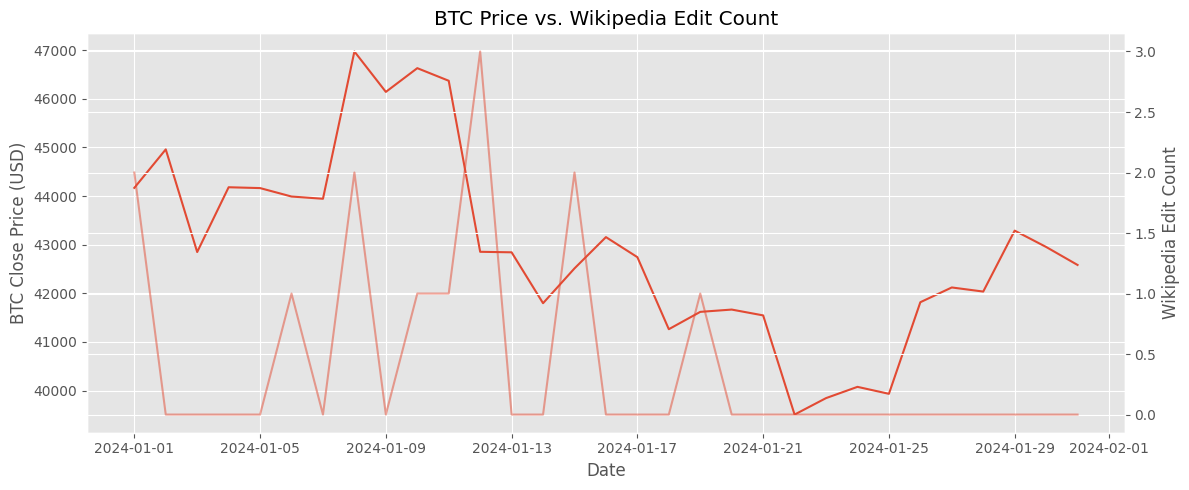

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

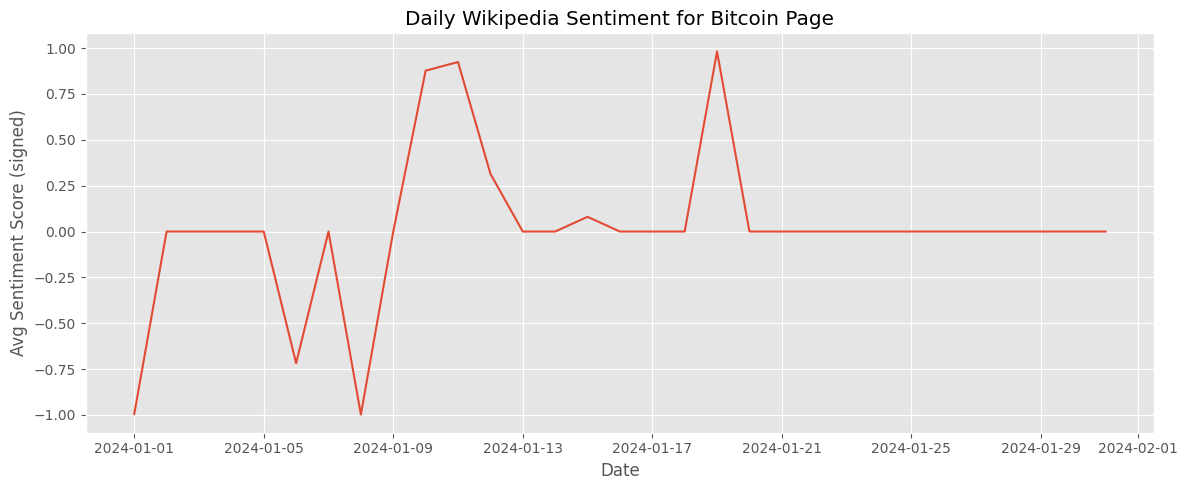

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 5))

ax1.plot(merged['date'], merged['close'], label='BTC Close')
ax1.set_ylabel('BTC Close Price (USD)')
ax1.set_xlabel('Date')

ax2 = ax1.twinx()
ax2.plot(merged['date'], merged['edit_count'], alpha=0.5, label='Wiki Edit Count')
ax2.set_ylabel('Wikipedia Edit Count')

plt.title('BTC Price vs. Wikipedia Edit Count')
fig.tight_layout()
plt.show()

fig, ax1 = plt.subplots(figsize=(12, 5))
ax1.plot(merged['date'], merged['avg_sentiment_score'])
ax1.set_ylabel('Avg Sentiment Score (signed)')
ax1.set_xlabel('Date')
plt.title('Daily Wikipedia Sentiment for Bitcoin Page')
fig.tight_layout()
plt.show()

## 7. Build a Simple Predictive Model
We use a simple **logistic regression** model to predict whether the next-day return is positive (`target_up`).

Features:
- `edit_count`
- `avg_sentiment_score`
- `pos_frac`
- `neg_frac`
- `comment_count`

You can easily extend this with more technical features (moving averages, volatility, etc.).

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Drop rows with missing target
model_df = merged.dropna(subset=['target_up']).copy()

feature_cols = ['edit_count', 'avg_sentiment_score', 'pos_frac', 'neg_frac', 'comment_count']
X = model_df[feature_cols].values
y = model_df['target_up'].values

# Train-test split by time (no shuffling to avoid lookahead bias)
split_idx = int(0.7 * len(model_df))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000))
])

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"Test Accuracy: {acc:.4f}")
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

Test Accuracy: 0.5000
Confusion Matrix:
 [[5 0]
 [5 0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67         5
           1       0.00      0.00      0.00         5

    accuracy                           0.50        10
   macro avg       0.25      0.50      0.33        10
weighted avg       0.25      0.50      0.33        10



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

## 8. Simple Strategy Backtest
We create a **toy trading strategy**:

- Each day in the test period, use the model to predict `target_up`
- If predicted **up**, we go **long** for the next day (PnL = next_return)
- If predicted **down**, we go **flat** (PnL = 0)

This is *not* a realistic backtest (no transaction costs, slippage, or risk constraints), but it is enough to check if the signal has any predictive power.

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

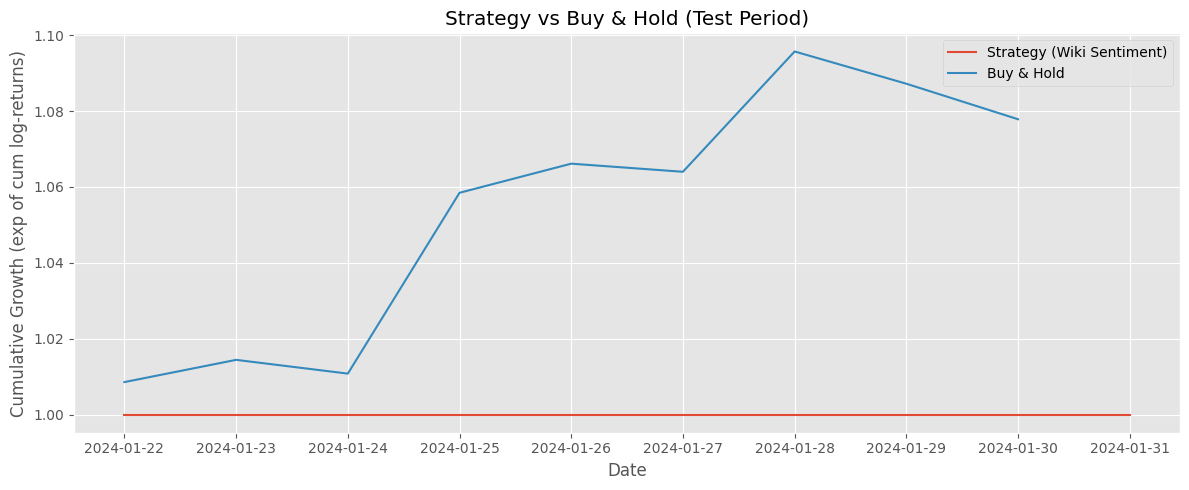

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

Final Strategy Growth (test): 1.000
Final Buy & Hold Growth (test): nan


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [ ]:
test_df = model_df.iloc[split_idx:].copy().reset_index(drop=True)
X_test_full = test_df[feature_cols].values
y_pred_test = pipe.predict(X_test_full)

test_df['pred_up'] = y_pred_test

# Strategy return: if we predict up, take next_return; otherwise 0
test_df['strategy_return'] = np.where(test_df['pred_up'] == 1,
                                       test_df['next_return'], 0.0)

# Cumulative returns
test_df['cum_strategy'] = test_df['strategy_return'].cumsum().apply(np.exp)
test_df['cum_buy_hold'] = test_df['next_return'].cumsum().apply(np.exp)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(test_df['date'], test_df['cum_strategy'], label='Strategy (Wiki Sentiment)')
ax.plot(test_df['date'], test_df['cum_buy_hold'], label='Buy & Hold')
ax.set_ylabel('Cumulative Growth (exp of cum log-returns)')
ax.set_xlabel('Date')
ax.legend()
plt.title('Strategy vs Buy & Hold (Test Period)')
fig.tight_layout()
plt.show()

final_strategy = test_df['cum_strategy'].iloc[-1]
final_buy_hold = test_df['cum_buy_hold'].iloc[-1]
print(f"Final Strategy Growth (test): {final_strategy:.3f}")
print(f"Final Buy & Hold Growth (test): {final_buy_hold:.3f}")

## 9. Next Steps / Extensions
- Add **technical indicators**: moving averages, RSI, volatility, etc.
- Use a more sophisticated **sentiment model** (finance-specific, multi-class).
- Add **lagged features** (previous days' sentiment and edit activity).
- Use proper **walk-forward validation** and **transaction costs**.
- Experiment with tree-based models (Random Forest, XGBoost) or deep learning.

---